#  <h1><center>A Comprehensive Analysis of Preprocessing for Word Representation Learning in Affective Tasks Implementation</center></h1>

In this work, we implement four text processing techniques namely, stopword removal, Stemming and Post tagg then, we apply it to the training corpus before the models start to learn the word embedding. In first place, we perform each tool individually to evaluate its effect on the performance results then, in second place we use all the processing factors together. On other hand, we incorporate only basic processing into the text used as input for the classification.
Implementing negation and Spellercheck techniques requires constracting the antonym dictionary and the customized dictionary of correction, which takes to much time. We will not implement them, but since we are working on an affective task we remove negation expression from stop word list such as 'no', 'never', 'neither'...
Due to the performance limit of our machines we used only two word embedding models: CBOW and Skip-gram. For the training corpus, we took only one third of the News articles.

# Import Librairies

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from keras.layers import Input, Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
import gc
from numpy import array
from numpy import asarray
from numpy import zeros
from gensim.models import Word2Vec
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# Helper Functions

In [ ]:
def embeddings(path):
  embeddings_dictionary = dict()
  glove_file = open(path, encoding="utf8")

  for line in glove_file:
      records = line.split()
      word = records[0]
      vector_dimensions = asarray(records[1:])
      embeddings_dictionary [word] = vector_dimensions
  glove_file.close()
  embedding_matrix = zeros((vocab_size, 300))
  for word, index in tokenizer.word_index.items():
      embedding_vector = embeddings_dictionary.get(word)
      if embedding_vector is not None:
          embedding_matrix[index] = embedding_vector
  return embedding_matrix

In [ ]:
def get_model(X_train, y_train, embedding_matrix, name):
  model = Sequential()
  embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
  model.add(embedding_layer)
  model.add(LSTM(128))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
  path = "../Weights/"+name+".h5"
  mc = ModelCheckpoint(path, monitor='val_acc',
                       mode='max', verbose=1, save_best_only=True)
	# fit model
  model.fit(X_train, y_train, batch_size=128, epochs=10000, verbose=1, validation_split=0.10, callbacks=[es, mc])
  return model, path


In [ ]:
def eval_model(path):
  saved_model =  load_model(path)
  yhat_probs = saved_model.predict(X_test, verbose=1)
  # predict crisp classes for test set
  yhat_classes = saved_model.predict_classes(X_test, verbose=1)
  # reduce to 1d array
  yhat_probs = yhat_probs[:, 0]
  yhat_classes = yhat_classes[:, 0]
  
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test, yhat_classes)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_test, yhat_classes)
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_test, yhat_classes)
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test, yhat_classes)
  print('F1 score: %f' % f1)

# Data Preparation

In [ ]:
path = "../data/IMDB Dataset.csv"
movie_reviews = pd.read_csv(path)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
text= movie_reviews['review']
X=text.values.tolist()

In [ ]:
def majid(X):
    corpus = []
    for i in range(0, len(X)):
        #review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"]', '',str(X[i])) #remove punctuation
        review = re.sub(r'\d+',' ', str(X[i]))# remove number
        review = review.lower() #lower case
        review = re.sub(r'\s+', ' ', review) #remove extra space
        review = re.sub(r'<[^>]+>','',review) #remove Html tags
        review = re.sub(r'\s+', ' ', review) #remove spaces
        review = re.sub(r"^\s+", '', review) #remove space from start
        review = re.sub(r'\s+$', '', review) #remove space from the end
        corpus.append(review)        
#    return corpus        
    #Tokenizing and Word Count  
    words=[]
    for i in range(len(corpus)):
        words= nltk.word_tokenize(corpus[i])
        #sentences.append(words)
   
    return words

In [ ]:
X = [[el] for el in X] 

from joblib import Parallel, delayed
import multiprocessing

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
num_cores = multiprocessing.cpu_count()
sentences = Parallel(n_jobs=num_cores)(delayed(majid)(i) for i in X)

In [ ]:
X = [' '.join(x) for x in sentences]
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print('Vocab size:',vocab_size)
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Vocab size: 98434


# Stemming

In [ ]:
# Embeddings path
path_emb = "../Embeddings/"

In [ ]:
embedding_matrix = embeddings(path_emb + "W-Skip-Stem.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 6s 17ms/step - loss: 0.6481 - acc: 0.6044 - val_loss: 0.5429 - val_acc: 0.7230

Epoch 00001: val_acc improved from -inf to 0.72300, saving model to /content/drive/MyDrive/NLP/W-Skip-Stem.h5
Epoch 2/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.5155 - acc: 0.7458 - val_loss: 0.4757 - val_acc: 0.7720

Epoch 00002: val_acc improved from 0.72300 to 0.77200, saving model to /content/drive/MyDrive/NLP/W-Skip-Stem.h5
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4725 - acc: 0.7769 - val_loss: 0.4652 - val_acc: 0.7720

Epoch 00003: val_acc did not improve from 0.77200
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4470 - acc: 0.7933 - val_loss: 0.4611 - val_acc: 0.7828

Epoch 00004: val_acc improved from 0.77200 to 0.78275, saving model to /content/drive/MyDrive/NLP/W-Skip-Stem.h5
Epoch 5/10000
282/282 [==============================] - 4s 15ms/s

In [ ]:
eval_model(path)

 39/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.821800
Precision: 0.816152
Recall: 0.834293
F1 score: 0.825123


In [ ]:
embedding_matrix = embeddings(path_emb + "W-CBOW-Stem.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 6s 17ms/step - loss: 0.6159 - acc: 0.6482 - val_loss: 0.5126 - val_acc: 0.7577

Epoch 00001: val_acc improved from -inf to 0.75775, saving model to /content/drive/MyDrive/NLP/W-CBOW-Stem.h5
Epoch 2/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4828 - acc: 0.7701 - val_loss: 0.4771 - val_acc: 0.7740

Epoch 00002: val_acc improved from 0.75775 to 0.77400, saving model to /content/drive/MyDrive/NLP/W-CBOW-Stem.h5
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4391 - acc: 0.7941 - val_loss: 0.4441 - val_acc: 0.7983

Epoch 00003: val_acc improved from 0.77400 to 0.79825, saving model to /content/drive/MyDrive/NLP/W-CBOW-Stem.h5
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4094 - acc: 0.8150 - val_loss: 0.4569 - val_acc: 0.7975

Epoch 00004: val_acc did not improve from 0.79825
Epoch 5/10000
282/282 [==============================] - 4s 15ms/s

In [ ]:
eval_model(path)

 40/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.823000
Precision: 0.819301
Recall: 0.832308
F1 score: 0.825753


We note ,in the case of applying only stemming, that the embedding generated using CBOW and Skip gram leads almost to the same results in the classification task.

# Punctuation

In [ ]:
embedding_matrix = embeddings(path_emb + "W-Skip-Punc.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 6s 17ms/step - loss: 0.6049 - acc: 0.6607 - val_loss: 0.4561 - val_acc: 0.7908

Epoch 00001: val_acc improved from -inf to 0.79075, saving model to /content/drive/MyDrive/NLP/W-Skip-Punc.h5
Epoch 2/10000
282/282 [==============================] - 4s 16ms/step - loss: 0.4756 - acc: 0.7754 - val_loss: 0.4424 - val_acc: 0.8033

Epoch 00002: val_acc improved from 0.79075 to 0.80325, saving model to /content/drive/MyDrive/NLP/W-Skip-Punc.h5
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4199 - acc: 0.8107 - val_loss: 0.3840 - val_acc: 0.8227

Epoch 00003: val_acc improved from 0.80325 to 0.82275, saving model to /content/drive/MyDrive/NLP/W-Skip-Punc.h5
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.3789 - acc: 0.8336 - val_loss: 0.3567 - val_acc: 0.8418

Epoch 00004: val_acc improved from 0.82275 to 0.84175, saving model to /content/drive/MyDrive/NLP/W-Skip-Punc.h5
Epo

In [ ]:
eval_model(path)

 37/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.862900
Precision: 0.844090
Recall: 0.892836
F1 score: 0.867779


In [ ]:
embedding_matrix = embeddings(path_emb + "W-CBOW-Punc.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 7s 17ms/step - loss: 0.5924 - acc: 0.6671 - val_loss: 0.4615 - val_acc: 0.7860

Epoch 00001: val_acc improved from -inf to 0.78600, saving model to /content/drive/MyDrive/NLP/W-CBOW-Punc.h5
Epoch 2/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4548 - acc: 0.7909 - val_loss: 0.3998 - val_acc: 0.8145

Epoch 00002: val_acc improved from 0.78600 to 0.81450, saving model to /content/drive/MyDrive/NLP/W-CBOW-Punc.h5
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.3935 - acc: 0.8221 - val_loss: 0.3755 - val_acc: 0.8295

Epoch 00003: val_acc improved from 0.81450 to 0.82950, saving model to /content/drive/MyDrive/NLP/W-CBOW-Punc.h5
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.3473 - acc: 0.8482 - val_loss: 0.4077 - val_acc: 0.8112

Epoch 00004: val_acc did not improve from 0.82950
Epoch 5/10000
282/282 [==============================] - 4s 15ms/s

In [ ]:
eval_model(path)

 40/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.851500
Precision: 0.835157
Recall: 0.878746
F1 score: 0.856397


# Stop Words

In [ ]:
embedding_matrix = embeddings(path_emb + "W-Skip-Stop.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 7s 17ms/step - loss: 0.5636 - acc: 0.7016 - val_loss: 0.4457 - val_acc: 0.7903

Epoch 00001: val_acc improved from -inf to 0.79025, saving model to /content/drive/MyDrive/NLP/W-Skip-Stop.h5
Epoch 2/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4508 - acc: 0.7915 - val_loss: 0.4093 - val_acc: 0.8130

Epoch 00002: val_acc improved from 0.79025 to 0.81300, saving model to /content/drive/MyDrive/NLP/W-Skip-Stop.h5
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4087 - acc: 0.8167 - val_loss: 0.3964 - val_acc: 0.8125

Epoch 00003: val_acc did not improve from 0.81300
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.3909 - acc: 0.8259 - val_loss: 0.4021 - val_acc: 0.8173

Epoch 00004: val_acc improved from 0.81300 to 0.81725, saving model to /content/drive/MyDrive/NLP/W-Skip-Stop.h5
Epoch 5/10000
282/282 [==============================] - 4s 15ms/s

In [ ]:
eval_model(path)

 40/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.842900
Precision: 0.846523
Recall: 0.840643
F1 score: 0.843573


In [ ]:
embedding_matrix = embeddings(path_emb + "W-CBOW-Stop.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 7s 17ms/step - loss: 0.5838 - acc: 0.6883 - val_loss: 0.4434 - val_acc: 0.7903

Epoch 00001: val_acc improved from -inf to 0.79025, saving model to /content/drive/MyDrive/NLP/W-CBOW-Stop.h5
Epoch 2/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4446 - acc: 0.7962 - val_loss: 0.4053 - val_acc: 0.8105

Epoch 00002: val_acc improved from 0.79025 to 0.81050, saving model to /content/drive/MyDrive/NLP/W-CBOW-Stop.h5
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4019 - acc: 0.8173 - val_loss: 0.3825 - val_acc: 0.8250

Epoch 00003: val_acc improved from 0.81050 to 0.82500, saving model to /content/drive/MyDrive/NLP/W-CBOW-Stop.h5
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.3639 - acc: 0.8374 - val_loss: 0.3821 - val_acc: 0.8248

Epoch 00004: val_acc did not improve from 0.82500
Epoch 5/10000
282/282 [==============================] - 4s 15ms/s

In [ ]:
eval_model(path)

 39/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.841000
Precision: 0.863282
Recall: 0.813257
F1 score: 0.837523


# POS Tagger

In [ ]:
path = "/content/drive/MyDrive/NLP/W-Skip-POS.txt"
embedding_matrix = embeddings(path_emb + "W-Skip-POS.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 6s 17ms/step - loss: 0.6125 - acc: 0.6432 - val_loss: 0.4463 - val_acc: 0.7878

Epoch 00001: val_acc improved from -inf to 0.78775, saving model to /content/drive/MyDrive/NLP/W-Skip-POS.h5
Epoch 2/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4549 - acc: 0.7881 - val_loss: 0.5537 - val_acc: 0.7245

Epoch 00002: val_acc did not improve from 0.78775
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4410 - acc: 0.7942 - val_loss: 0.3825 - val_acc: 0.8248

Epoch 00003: val_acc improved from 0.78775 to 0.82475, saving model to /content/drive/MyDrive/NLP/W-Skip-POS.h5
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.3735 - acc: 0.8353 - val_loss: 0.4000 - val_acc: 0.8250

Epoch 00004: val_acc improved from 0.82475 to 0.82500, saving model to /content/drive/MyDrive/NLP/W-Skip-POS.h5
Epoch 5/10000
282/282 [==============================] - 4s 15ms/step

In [ ]:
eval_model(path)

 38/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.859500
Precision: 0.875879
Recall: 0.840246
F1 score: 0.857693


In [ ]:
embedding_matrix = embeddings(path_emb + "W-CBOW-POS.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 7s 17ms/step - loss: 0.6053 - acc: 0.6530 - val_loss: 0.4571 - val_acc: 0.7883

Epoch 00001: val_acc improved from -inf to 0.78825, saving model to /content/drive/MyDrive/NLP/W-CBOW-POS.h5
Epoch 2/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4425 - acc: 0.7956 - val_loss: 0.4018 - val_acc: 0.8130

Epoch 00002: val_acc improved from 0.78825 to 0.81300, saving model to /content/drive/MyDrive/NLP/W-CBOW-POS.h5
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.3900 - acc: 0.8240 - val_loss: 0.4006 - val_acc: 0.8130

Epoch 00003: val_acc did not improve from 0.81300
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.3313 - acc: 0.8554 - val_loss: 0.3588 - val_acc: 0.8482

Epoch 00004: val_acc improved from 0.81300 to 0.84825, saving model to /content/drive/MyDrive/NLP/W-CBOW-POS.h5
Epoch 5/10000
282/282 [==============================] - 4s 15ms/step

In [ ]:
eval_model(path)

 39/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.857700
Precision: 0.860447
Recall: 0.856519
F1 score: 0.858478


**Comment**  
The previous results show that each text processing tool impacts differently the classification model perfomance while intragrating it into the training corpus before generating the words embedding. We note that CBOW is litte bit much better than Skip gram in many cases. This can be explained by the fact that Skip gram represents well even rare words or phrases and CBOW is slightly better accuracy for the frequent words.

# All preprocessing data

In [ ]:
embedding_matrix = embeddings(path_emb + "W-Skip-ALL.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 38s 17ms/step - loss: 0.6338 - acc: 0.6317 - val_loss: 0.5397 - val_acc: 0.7268

Epoch 00001: val_acc improved from -inf to 0.72675, saving model to /content/drive/MyDrive/NLP/W-Skip-ALL.h5
Epoch 2/10000
282/282 [==============================] - 4s 14ms/step - loss: 0.5239 - acc: 0.7421 - val_loss: 0.5425 - val_acc: 0.7450

Epoch 00002: val_acc improved from 0.72675 to 0.74500, saving model to /content/drive/MyDrive/NLP/W-Skip-ALL.h5
Epoch 3/10000
282/282 [==============================] - 4s 14ms/step - loss: 0.4912 - acc: 0.7630 - val_loss: 0.4985 - val_acc: 0.7490

Epoch 00003: val_acc improved from 0.74500 to 0.74900, saving model to /content/drive/MyDrive/NLP/W-Skip-ALL.h5
Epoch 4/10000
282/282 [==============================] - 4s 14ms/step - loss: 0.4655 - acc: 0.7757 - val_loss: 0.4858 - val_acc: 0.7588

Epoch 00004: val_acc improved from 0.74900 to 0.75875, saving model to /content/drive/MyDrive/NLP/W-Skip-ALL.h5
Epoch 

In [ ]:
eval_model(path)

 39/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.798300
Precision: 0.793057
Recall: 0.811471
F1 score: 0.802158


In [ ]:
embedding_matrix = embeddings(path_emb + "W-CBOW-ALL.txt")
model, path = get_model(X_train, y_train, embedding_matrix, path.split("/")[-1].split(".")[0])

Epoch 1/10000
282/282 [==============================] - 6s 16ms/step - loss: 0.6012 - acc: 0.6647 - val_loss: 0.5049 - val_acc: 0.7520

Epoch 00001: val_acc improved from -inf to 0.75200, saving model to /content/drive/MyDrive/NLP/W-CBOW-ALL.h5
Epoch 2/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.5007 - acc: 0.7562 - val_loss: 0.4873 - val_acc: 0.7615

Epoch 00002: val_acc improved from 0.75200 to 0.76150, saving model to /content/drive/MyDrive/NLP/W-CBOW-ALL.h5
Epoch 3/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4696 - acc: 0.7804 - val_loss: 0.5089 - val_acc: 0.7550

Epoch 00003: val_acc did not improve from 0.76150
Epoch 4/10000
282/282 [==============================] - 4s 15ms/step - loss: 0.4521 - acc: 0.7881 - val_loss: 0.4593 - val_acc: 0.7722

Epoch 00004: val_acc improved from 0.76150 to 0.77225, saving model to /content/drive/MyDrive/NLP/W-CBOW-ALL.h5
Epoch 5/10000
282/282 [==============================] - 4s 15ms/step

In [ ]:
eval_model(path)

 37/313 [==>...........................] - ETA: 1s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 1s 4ms/step
Accuracy: 0.790600
Precision: 0.779465
Recall: 0.815043
F1 score: 0.796857


In [4]:
results = pd.read_csv('F1_score_results.csv',index_col=0)
results

,technique,Score,Model
0,stem,0.825123,Skip-gram
1,stem,0.825753,CBOW
2,punc,0.867779,Skip-gram
3,punc,0.856397,CBOW
4,stop,0.843573,Skip-gram
5,stop,0.837523,CBOW
6,post-tag,0.857693,Skip-gram
7,post-tag,0.858478,CBOW
8,All,0.802158,Skip-gram
9,All,0.796857,CBOW


Text(0.5, 1.0, 'The effect of text processing tools on the classification models performance')

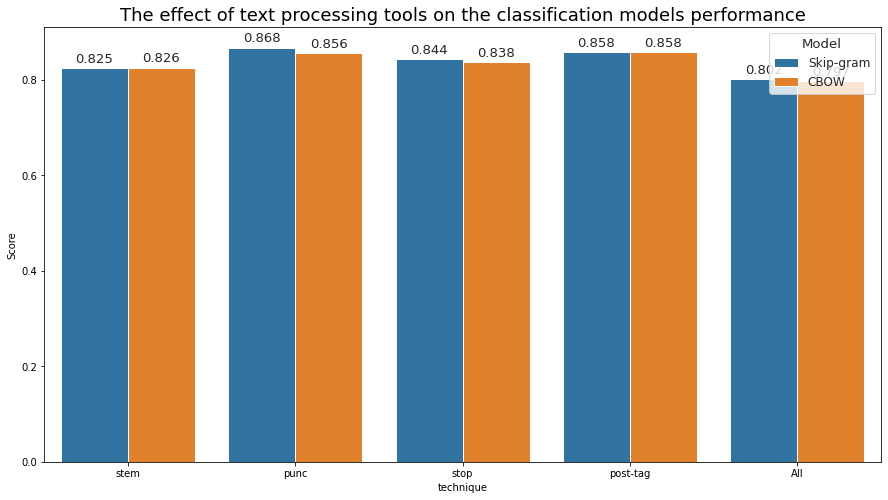

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(15,8))
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 2.5})
sns.set_style("whitegrid")
g = sns.barplot(x="technique", y="Score", hue="Model", data=results)
for p in g.patches:
    g.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title("The effect of text processing tools on the classification models performance",size=18)

The figure above shows the effectiveness of using each processing technique earlier on the training corpus before learning the word embeddings with CBOW and Skip-gram. As we can see, applying all the tools together harm the classification models perfomance. So the choice of the right combination depend on the affective task. Among all the factors, Stemming and Stopword removal are the worse ones which demonstrated previously in the paper. 